<a href="https://colab.research.google.com/github/bitnurihan/Capstone_Project_Starbucks/blob/master/Analysing_starbucks_location_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Data Science Capstone Project : The Battle of Neighborhoods

# **STRATEGIC ANALYSIS OF STARBUCKS CORPORATION**


## 1.1 Importing Libraries.

In [0]:
import warnings
warnings.filterwarnings('ignore')
# warning message deletion
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')

In [2]:
import requests

from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1.2 Reading Data from file (Toronto)

In [4]:
# reading population/income/worker data
df = pd.read_csv('/content/drive/My Drive/Starbucks/neighbourhood-profiles-2016.csv')
df.head()

,_id,Category,Topic,DataSource,Characteristic,CityofToronto,AgincourtNorth,AgincourtSouth-MalvernWest,Alderwood,Annex,Banbury-DonMills,BathurstManor,BayStreetCorridor,BayviewVillage,BayviewWoods-Steeles,BedfordPark-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,BlackCreek,Blake-Jones,BriarHill-Belgravia,BridlePath-Sunnybrook-YorkMills,BroadviewNorth,Brookhaven-Amesbury,Cabbagetown-SouthSt.JamesTown,Caledonia-Fairbank,CasaLoma,CentennialScarborough,Church-YongeCorridor,Clairlea-Birchmount,ClantonPark,Cliffcrest,CorsoItalia-Davenport,Danforth,DanforthEastYork,DonValleyVillage,DorsetPark,Dovercourt-WallaceEmerson-Junction,Downsview-Roding-CFB,...,RegentPark,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-MoorePark,Rouge,Runnymede-BloorWestVillage,Rustic,ScarboroughVillage,SouthParkdale,SouthRiverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,TamO'Shanter-Sullivan,Taylor-Massey,TheBeaches,Thistletown-BeaumondHeights,ThorncliffePark,Trinity-Bellwoods,University,VictoriaVillage,WaterfrontCommunities-TheIsland,WestHill,WestHumber-Clairville,Westminster-Branson,Weston,Weston-PelhamPark,Wexford/Maryvale,WillowdaleEast,WillowdaleWest,Willowridge-Martingrove-Richview,Woburn,WoodbineCorridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,YorkUniversityHeights,Yorkdale-GlenPark
0,1,NeighbourhoodInformation,NeighbourhoodInformation,CityofToronto,NeighbourhoodNumber,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,...,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,NeighbourhoodInformation,NeighbourhoodInformation,CityofToronto,TSNS2020Designation,NaN,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NIA,NoDesignation,NoDesignation,NIA,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,EmergingNeighbourhood,NoDesignation,NIA,...,NIA,NoDesignation,NIA,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NIA,NIA,NIA,NoDesignation,NoDesignation,EmergingNeighbourhood,NoDesignation,NoDesignation,NIA,NoDesignation,NIA,NIA,NoDesignation,NoDesignation,NIA,NoDesignation,NIA,NoDesignation,EmergingNeighbourhood,NIA,NIA,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NIA,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NoDesignation,NIA,EmergingNeighbourhood
2,3,Population,Populationanddwellings,CensusProfile98-316-X2016001,Population2016,2731571,29113,23757,12054,30526,27695,15873,25797,21396,13154,23236,6577,29960,22291,21737,7727,14257,9266,11499,17757,11669,9955,10968,13362,31340,26984,16472,15935,14133,9666,17180,27051,25003,36625,35052,...,10803,10529,22246,14974,20923,46496,10070,9941,16724,21849,27876,17812,24623,25051,27446,15683,21567,10360,21108,16556,7607,17510,65913,27392,33312,26274,17992,11098,27917,50434,16936,22156,53485,12541,7865,14349,11817,12528,27593,14804
3,4,Population,Populationanddwellings,CensusProfile98-316-X2016001,Population2011,2615060,30279,21988,11904,29177,26918,15434,19348,17671,13530,23185,6488,27876,21856,22057,7763,14302,8713,11563,17787,12053,9851,10487,13093,28349,24770,14612,15703,13743,9444,16712,26739,24363,34631,34659,...,10007,10488,22267,15050,20631,45912,9632,9951,16609,21251,25642,17958,25017,24691,27398,15594,21130,10138,19225,16802,7782,17182,43361,26547,34100,25446,18170,12010,27018,45041,15004,21343,53350,11703,7826,13986,10578,11652,27713,14687
4,5,Population,Populationanddwellings,CensusProfile98-316-X2016001,PopulationChange2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,2.80%,33.30%,21.10%,-2.80%,0.20%,1.40%,7.50%,2.00%,-1.50%,-0.50%,-0.30%,6.30%,-0.60%,-0.20%,-3.20%,1.10%,4.60%,2.10%,10.60%,8.90%,12.70%,1.50%,2.80%,2.40%,2.

In [5]:
df_t = df.transpose() # transpose the dataframe for setting index to neibourhood name 
df_t = df_t.iloc[4:,:]
df_t = df_t.rename(columns=df_t.iloc[0])
df_t = df_t.iloc[2:]
# selecting data be used
df_canada = df_t[['NeighbourhoodNumber', 'Population2016','Marketincome:Populationwithanamount','Marketincome:Averageamount($)']] 
df_canada.columns = ['Neighbourhood Number', 'Population', 'the number of employee',	'average annual income($)']
# Changing data type from str to int
df_canada['Neighbourhood Number'] = df_canada['Neighbourhood Number'].astype(int)
df_canada['Population'] = df_canada['Population'].astype(int)
df_canada['the number of employee'] = df_canada['the number of employee'].astype(int)
df_canada['average annual income($)'] = df_canada['average annual income($)'].astype(int)
df_canada.head()

,Neighbourhood Number,Population,the number of employee,average annual income($)
AgincourtNorth,129,29113,19610,30017
AgincourtSouth-MalvernWest,128,23757,16490,31854
Alderwood,20,12054,9045,46761
Annex,95,30526,23725,117981
Banbury-DonMills,42,27695,20470,68234


In [0]:
# Reading starbucks data
toronto_starbucks = pd.read_csv('/content/drive/My Drive/Starbucks/all-starbucks-locations-in-toronto.csv', sep=';')
toronto_starbucks['Postal Code'] = toronto_starbucks['Postal Code'].str[:3]
toronto_starbucks.head()

,Name,Brand,Store Number,Phone Number,Ownership Type,Street Combined,Street 1,Street 2,Street 3,City,Country Subdivision,Country,Postal Code,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone,First Seen
0,Kingston Rd & Bingham Ave,Starbucks,4719-101643,416-686-1309,CO,1020 Kingston Road,1020 Kingston Road,NaN,NaN,Toronto,ON,CA,M4E,"43.6808815002,-79.2849731445",43.680882,-79.284973,Eastern Standard Time,-300,GMT-05:00 America/Toronto,2013-12-08T14:41:59-08:00
1,Yonge & Eglinton Indigo,Starbucks,4508-93343,416-487-2330,CO,2300 Yonge St,2300 Yonge St,NaN,NaN,Toronto,ON,CA,M4P,"43.7076148987,-79.3986816406",43.707615,-79.398682,Eastern Standard Time,-300,GMT-05:00 America/Toronto,2013-12-08T14:41:59-08:00
2,Yonge & Finch,Starbucks,4717-102447,416-221-4820,CO,"5650 Yonge St, Suite 101",5650 Yonge St,Suite 101,NaN,Toronto,ON,CA,M2M,"43.7798843384,-79.4162216187",43.779884,-79.416222,Eastern Standard Time,-300,GMT-05:00 America/Toronto,2013-12-08T14:41:59-08:00
3,Yonge @ Rose Hill,Starbucks,4282-879,(416) 920-5955,CO,5 Rose Hill Ave.,5 Rose Hill Ave.,NaN,NaN,Toronto,ON,CA,M5V,"43.6861000061,-79.3929367065",43.686100,-79.392937,Eastern Standard Time,-300,GMT-05:00 America/Toronto,2013-12-08T14:41:59-08:00
4,Hospital for Sick Children,Starbucks,4225-767,(416) 977-0855,CO,"555 University Avenue, The Hospital for Sick C...",555 University Avenue,NaN,The Hospital for Sick Children,Toronto,ON,CA,M5G,"43.657749176,-79.3875045776",43.657749,-79.387505,Eastern Standard Time,-300,GMT-05:00 America/Toronto,2013-12-08T14:41:59-08:00


## 1.3 Getting coordinates of Toronto

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


## 1.4 Reading Data from JSON file (Toronto)

In [0]:
toronto_geo = open('/content/drive/My Drive/Starbucks/neighbourhoods_toronto.geojson').read()

## 1.5 Showing neighborhoods on the map using folium library (Toronto)

In [0]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
map_toronto.choropleth(geo_data = toronto_geo,
               data = df_canada,
               columns = ['Neighbourhood Number','average annual income($)'],
               fill_color = 'Purples',
               key_on = 'feature.properties.hoodnum',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)

for n in toronto_starbucks.index:
    # popup text setting
    popup_name = toronto_starbucks.loc[n, 'Brand'] + ' - ' + toronto_starbucks.loc[n, 'Street 1']
    folium.CircleMarker(
            location=[toronto_starbucks.loc[n,'Latitude'], toronto_starbucks.loc[n, 'Longitude']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(map_toronto)
    
map_toronto

## 2.1 Reading Data from file (Seoul)

In [8]:
shop_2019 = pd.read_csv('/content/drive/My Drive/Starbucks/store_seoul_201912_01.csv', encoding='utf-8', sep='|')
# selecting 'Seoul' data from dataframe
df_seoul = shop_2019.loc[shop_2019['시도명'].str.startswith('서울')].copy()
df_seoul.shape

(407376, 39)

## 2.2 Selecting 'starbucks' Data from df_seoul

In [10]:
df_starbucks = df_seoul[df_seoul['상호명'].str.contains('스타벅스|starbucks|STARBUCKS')]
df_starbucks.shape
df_starbucks['상호명'] = 'starbucks'
df_starbucks.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
1104,19976038,starbucks,이태원점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11170,용산구,1117065000,이태원1동,1117013000,이태원동,1117013000201270006,1,대지,127,6.0,서울특별시 용산구 이태원동 127-6,111703102009,서울특별시 용산구 이태원로,188,NaN,1117013000101270029009542,NaN,서울특별시 용산구 이태원로 188,140200,4406.0,NaN,NaN,29,126.994781,37.534303
2023,19998811,starbucks,종로3가점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11110,종로구,1111061500,종로1.2.3.4가동,1111015600,종로3가,1111015600200090003,1,대지,9,3.0,서울특별시 종로구 종로3가 9-3,111103100013,서울특별시 종로구 종로,113,1.0,1111015600100090003016323,NaN,서울특별시 종로구 종로 113-1,110123,3139.0,NaN,1,NaN,126.990207,37.570585
2770,20680373,starbucks,신사2점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11650,서초구,1165054000,잠원동,1165010600,잠원동,1165010600200280001,1,대지,28,1.0,서울특별시 서초구 잠원동 28-1,116502102001,서울특별시 서초구 강남대로,581,NaN,1165010600100280001019301,푸른빌딩,서울특별시 서초구 강남대로 581,137904,6530.0,NaN,2,NaN,127.019763,37.513663
14770,20283351,starbucks,NaN,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11560,영등포구,1156054000,여의동,1156011000,여의도동,1156011000200230000,1,대지,23,NaN,서울특별시 영등포구 여의도동 23,115603118002,서울특별시 영등포구 국제금융로,10,NaN,1156011000100230000000001,서울국제금융센터,서울특별시 영등포구 국제금융로 10,150945,7326.0,NaN,3,NaN,126.924863,37.525172
14781,20288646,starbucks,삼성역점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,비알콜 음료점업,11,서울특별시,11680,강남구,1168058000,삼성1동,1168010500,삼성동,1168010500201680026,1,대지,168,26.0,서울특별시 강남구 삼성동 168-26,116804166710,서울특별시 강남구 테헤란로103길,9,NaN,1168010500101680026016641,제일빌딩,서울특별시 강남구 테헤란로103길 9,135090,6173.0,NaN,1,NaN,127.063878,37.510038


##2.3 Grouping data by neighborhood (Seoul)

In [0]:
geo_df = df_starbucks
df_starbucks_brand = pd.DataFrame(
    df_starbucks.groupby(['시군구명'])['상호명'].count()
)
df_starbucks_brand.columns = ['the number of stores']
df_starbucks_brand.head()

,the number of stores
시군구명,
강남구,84
강동구,13
강북구,5
강서구,17
관악구,11


## 2.4 Reading income data and selecting data used

In [0]:
seoul_df = pd.read_excel('/content/drive/My Drive/Starbucks/seoul_income.xlsx', skiprows = 13, index_col=0)
seoul_income_df = seoul_df.iloc[:25,:3]
seoul_income_df.columns = ['eng name','the number of employee', 'average annual income']
seoul_income_df['average annual income'] = round(seoul_income_df['average annual income'] * 1000000 / seoul_income_df['the number of employee'],0)
seoul_income_df.head()

,eng name,the number of employee,average annual income
서울,,,
강남구,Gangnam-gu,206821.0,69642773.0
강동구,Gangdong-gu,165248.0,38071813.0
강북구,Gangbuk-gu,103391.0,28179687.0
강서구,Gangseo-gu,242516.0,36323785.0
관악구,Gwanak-gu,212016.0,30757580.0


## 2.5 Reading employee data from file and Selecting data used

In [0]:
employee_df = pd.read_excel('/content/drive/My Drive/Starbucks/seoul_employee.xlsx', skiprows = 13, index_col=0)
seoul_employee_df = employee_df.iloc[:25,:2]
seoul_employee_df.columns = ['eng name','the number of employee']
seoul_employee_df.head()

,eng name,the number of employee
서울,,
강남구,Gangnam-gu,955553.0
강동구,Gangdong-gu,111424.0
강북구,Gangbuk-gu,40465.0
강서구,Gangseo-gu,221810.0
관악구,Gwanak-gu,74556.0


##2.6 Reading population data from file and Selecting data used

In [0]:
seoul_population = pd.read_csv('/content/drive/My Drive/Starbucks/seoul_population.csv', index_col=0)
seoul_population.head()

,Total population,Household,Men,Women
행정구역,,,,
강남구,546436,233849,261466,284970
강동구,446887,187626,220464,226423
강북구,313289,144553,152857,160432
강서구,590419,263413,285619,304800
관악구,499587,269964,250822,248765


## 2.7 Concating data used in analyzing from multiple dataframe

In [0]:
seoul_full_df = pd.concat([seoul_employee_df['eng name'],seoul_population['Total population'],seoul_employee_df['the number of employee'], seoul_income_df['average annual income'], df_starbucks_brand['the number of stores']], axis=1)

seoul_full_df.head()

,eng name,Total population,the number of employee,average annual income,the number of stores
강남구,Gangnam-gu,546436,955553.0,69642773.0,84
강동구,Gangdong-gu,446887,111424.0,38071813.0,13
강북구,Gangbuk-gu,313289,40465.0,28179687.0,5
강서구,Gangseo-gu,590419,221810.0,36323785.0,17
관악구,Gwanak-gu,499587,74556.0,30757580.0,11


##2.8 Reading Data from JSON file (Seoul)

In [0]:
import json

state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

##2.9 Showing neighborhoods on the map using folium library (Seoul)

### 2.9.1 Annual income X the number of Starbucks store

In [0]:
income_map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

income_map.choropleth(geo_data = state_geo,
               data = seoul_income_df['average annual income'],
               columns = [seoul_income_df.index, seoul_income_df['average annual income']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(income_map)
        
income_map

### 2.9.2 the number of employee X the number of Starbucks store

In [0]:
employee_map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

employee_map.choropleth(geo_data = state_geo,
               data = seoul_employee_df['the number of employee'],
               columns = [seoul_employee_df.index, seoul_employee_df['the number of employee']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(employee_map)
employee_map

### 2.9.3 Population X the number of Starbucks store

In [0]:
population_map = folium.Map(location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
                 zoom_start=11)

population_map.choropleth(geo_data = state_geo,
               data = seoul_full_df['Total population'],
               columns = [seoul_full_df.index, seoul_full_df['Total population']],
               fill_color = 'Purples',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
for n in geo_df.index:
    # popup text setting
    popup_name = geo_df.loc[n, '상호명'] + ' - ' + geo_df.loc[n, '도로명주소']
    folium.CircleMarker(
            location=[geo_df.loc[n,'위도'], geo_df.loc[n, '경도']],
            radius=3,
            popup=popup_name,
            color= 'purple',
            fill=True,
            fill_color='purple'
        ).add_to(population_map)
population_map

## 3.1 Correlation Analysis between features (Seoul)

In [0]:
def heatMap(df, mirror):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

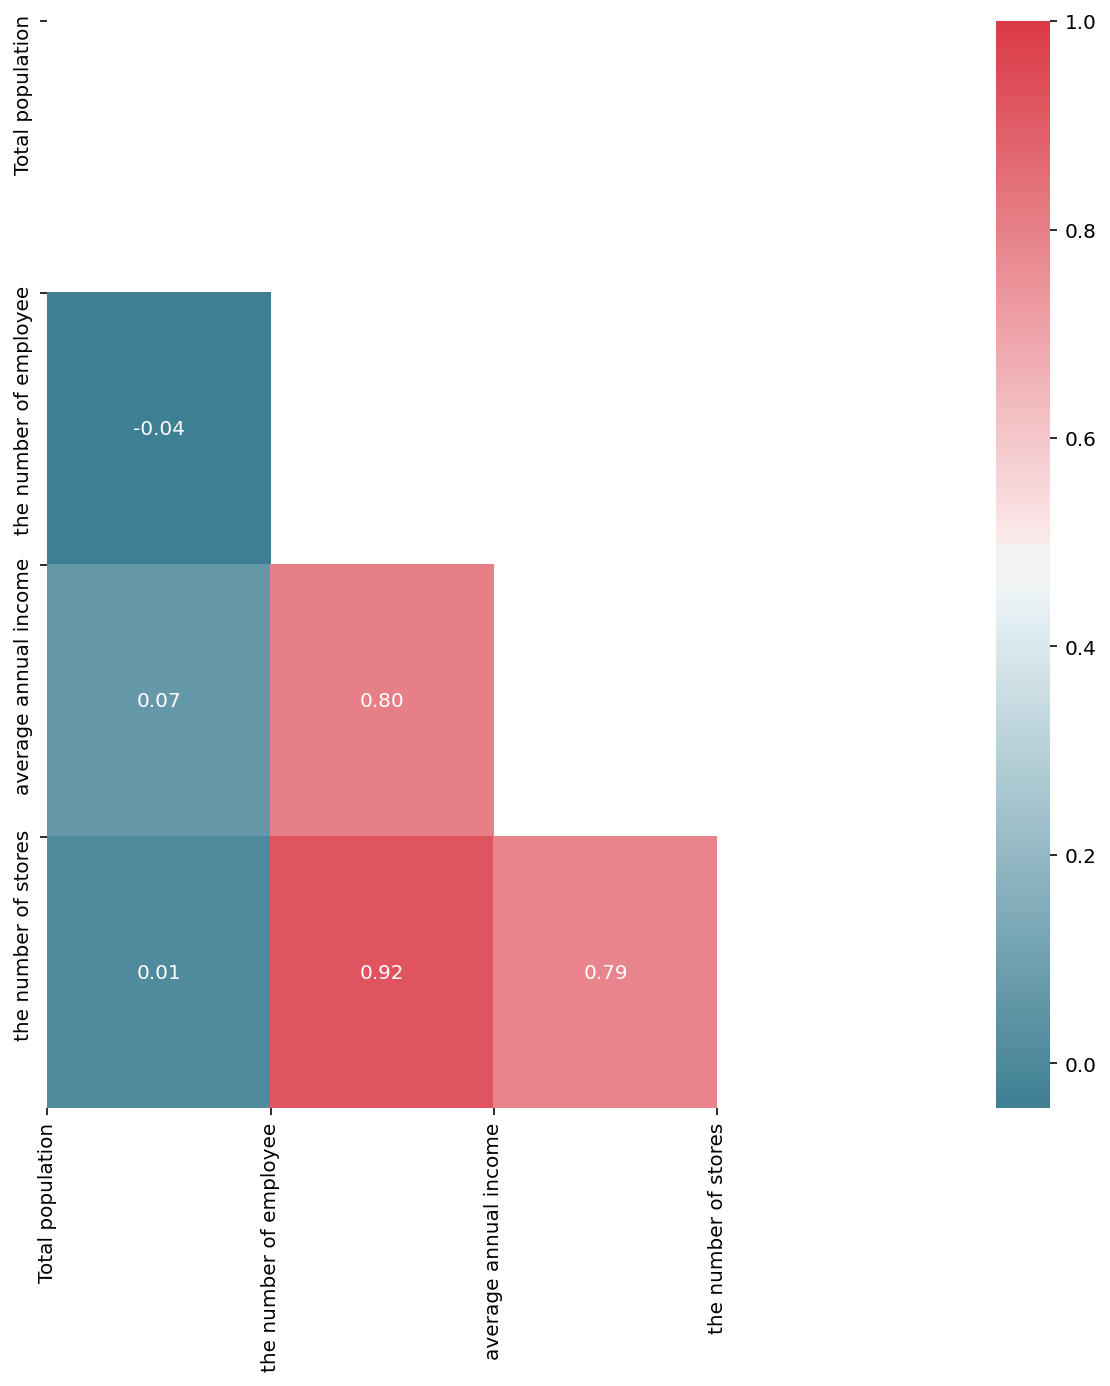

In [0]:
heatMap(seoul_full_df, mirror=False)

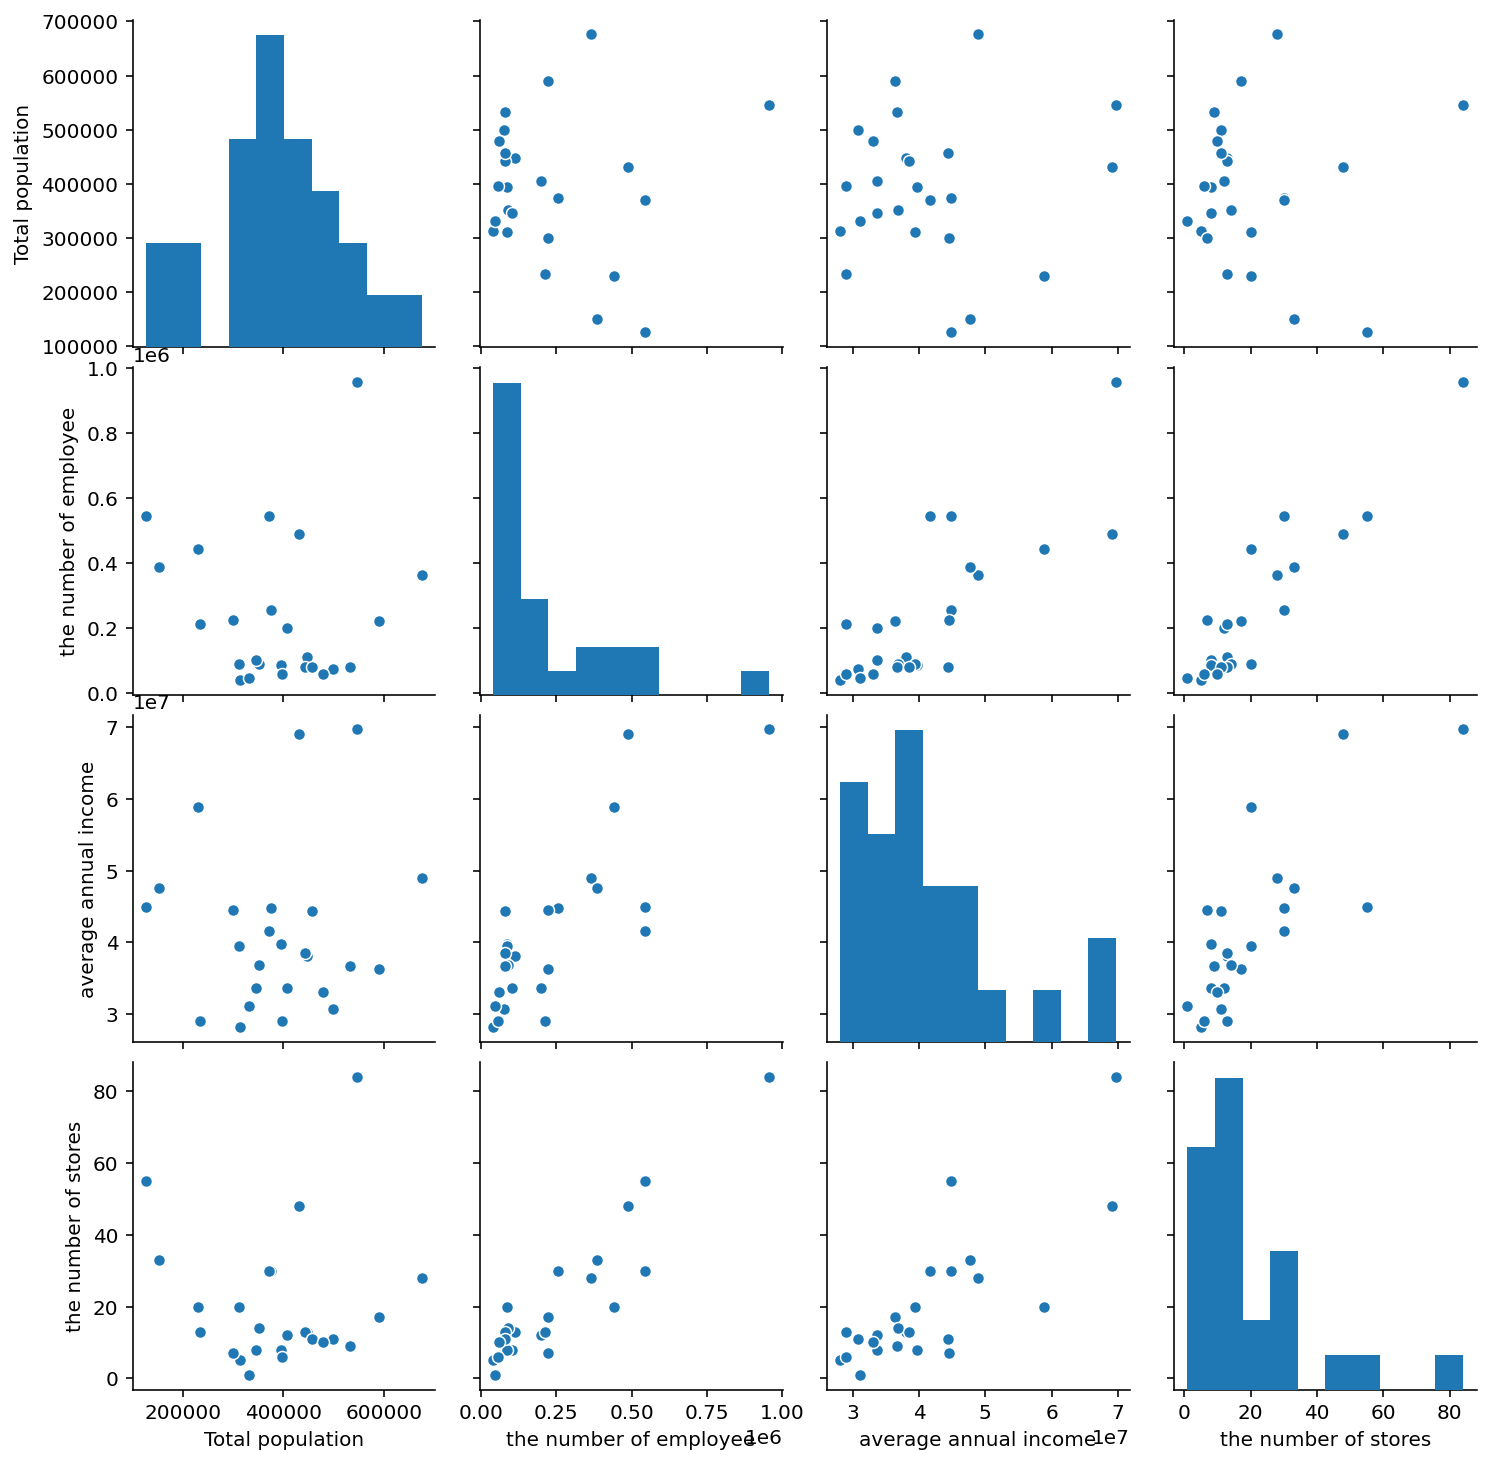

In [0]:
sns.pairplot(seoul_full_df)

# **Thank you**